In [1]:
using RRIFT, Plots, Interact
using Perfusion, MAT, Statistics, StatsBase

# Set this to true/false depending on whether a dark theme is being used in jupyter lab
is_dark = false

figopts = (framestyle = :grid, gridalpha=0.5, gridstyle=:dot, linewidth = 2.5, 
        tickfontsize = 11, fg_legend = :transparent, legendfontsize = 11)

if is_dark
    figopts = (figopts..., background_color=RGB(0.067, 0.067, 0.067))
end

lineopts(label::String) = (label = label, xlabel = "Time [min]", ylabel = "[Gd] [mM]", figopts...)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5323575632777131988\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6667128474406378421\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5323575632777131988\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

lineopts (generic function with 1 method)

# In-vivo analysis on glioblastoma multiforme (GBM)

This notebook will apply the reference region and input function tail (RRIFT) method on the in-vivo data.
The Tofts model will also be fitted.

## Downloading the pre-processed data

For simplcity, we will use the pre-processed data which were previously generated.

In [2]:
mat_dir = "./data/tcga-gbm-mat"
download_invivo_preprocessed(destination = mat_dir)
mat_files = readdir(mat_dir)

8-element Array{String,1}:
 "1.3.6.1.4.1.14519.5.2.1.4591.4001.100057969162276274933613772317.mat"
 "1.3.6.1.4.1.14519.5.2.1.4591.4001.269887096484012292940330991126.mat"
 "1.3.6.1.4.1.14519.5.2.1.4591.4001.278082550121070125285213632206.mat"
 "1.3.6.1.4.1.14519.5.2.1.4591.4001.304604545029494418165835320551.mat"
 "1.3.6.1.4.1.14519.5.2.1.4591.4001.335353575986269052491315637674.mat"
 "1.3.6.1.4.1.14519.5.2.1.4591.4001.365805576275232517344053939830.mat"
 "1.3.6.1.4.1.14519.5.2.1.4591.4001.763554173270318063812534542847.mat"
 "1.3.6.1.4.1.14519.5.2.1.4591.4001.961791689281776173751323306588.mat"

In [3]:
# List all the .mat files
mat_files = joinpath.(mat_dir, readdir(mat_dir))

8-element Array{String,1}:
 "./data/tcga-gbm-mat/1.3.6.1.4.1.14519.5.2.1.4591.4001.100057969162276274933613772317.mat"
 "./data/tcga-gbm-mat/1.3.6.1.4.1.14519.5.2.1.4591.4001.269887096484012292940330991126.mat"
 "./data/tcga-gbm-mat/1.3.6.1.4.1.14519.5.2.1.4591.4001.278082550121070125285213632206.mat"
 "./data/tcga-gbm-mat/1.3.6.1.4.1.14519.5.2.1.4591.4001.304604545029494418165835320551.mat"
 "./data/tcga-gbm-mat/1.3.6.1.4.1.14519.5.2.1.4591.4001.335353575986269052491315637674.mat"
 "./data/tcga-gbm-mat/1.3.6.1.4.1.14519.5.2.1.4591.4001.365805576275232517344053939830.mat"
 "./data/tcga-gbm-mat/1.3.6.1.4.1.14519.5.2.1.4591.4001.763554173270318063812534542847.mat"
 "./data/tcga-gbm-mat/1.3.6.1.4.1.14519.5.2.1.4591.4001.961791689281776173751323306588.mat"

## Pharmacokinetic modelling - Single patient example

The next few sections will fit the extended Tofts model and the RRIFT method on a single DCE-MRI study.

In [4]:
chosen_mat_file = mat_files[7]
mat_data = load_preprocessed_mat(chosen_mat_file)
@extract (t, ct, crr, cp, masks) mat_data

println("""
Loaded the following variables:
    - `t` is an $(typeof(t)) with length $(length(t))
    - `ct` is an $(typeof(ct)) with size $(size(ct))
    - `crr` is an $(typeof(crr)) with length $(length(crr))
    - `cp` is an $(typeof(cp)) with length $(length(cp))
    - `masks` is a $(typeof(masks)) with keys $(keys(masks))
""")

Loaded the following variables:
    - `t` is an Array{Float64,1} with length 70
    - `ct` is an Array{Float64,2} with size (15982, 70)
    - `crr` is an Array{Float64,1} with length 70
    - `cp` is an Array{Float64,1} with length 70
    - `masks` is a Dict{String,Any} with keys ["muscle", "tumour", "aif"]



### Extended tofts model fit

The extended tofts model has the form
$$
C_t(t) = K^{trans} \cdot C_p(t) \ast \exp(-k_{ep} \cdot t) + v_p \cdot C_p(t)
$$
where $C_t$ is the concentration in tissue, $C_p$ is the input function, and $t$ is the time, i.e. `ct`, `cp` and, `t` in the code, respectively.
The $\ast$ is a convolution while the fitting parameters are $K^{trans}$, $k_{ep}$, and $v_p$, along with a derived parameter $v_e = K^{trans} / k_{ep}$ (not shown in equation).

The input function along with concentration-time data for a single voxel are shown below:

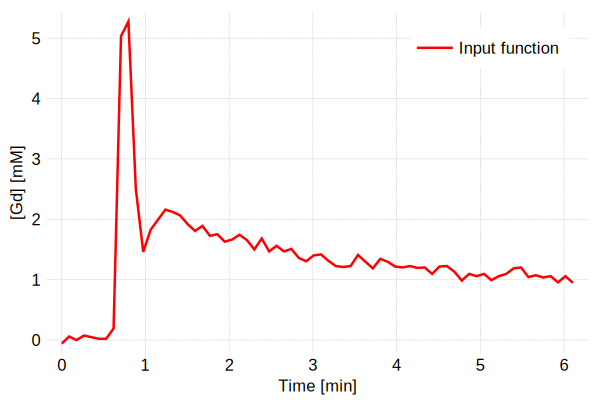

In [5]:
# Input function
plot(t, cp; lineopts("Input function")..., c=:red)

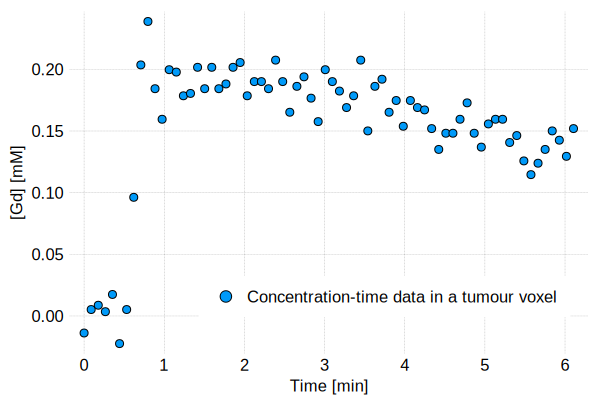

In [6]:
# Concentration vs time from a single tumour voxel
single_ct = ct[100, :]
scatter(t, single_ct; lineopts("Concentration-time data in a tumour voxel")..., legend=:bottomright)

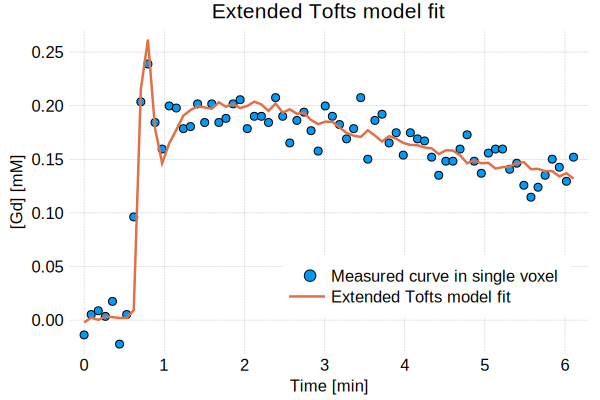

In [7]:
est_tofts = fit_model(:extendedtofts, :lls, ct = single_ct, t = t, cp = cp).estimates
fitted_curve = model_tofts(t = t, cp = cp, parameters=(kt = est_tofts.kt[1], kep = est_tofts.kep[1], vp = est_tofts.vp[1]))

scatter(t, single_ct; lineopts("Measured curve in single voxel")..., legend=:bottomright)
plot!(t, fitted_curve; title = "Extended Tofts model fit", lineopts("Extended Tofts model fit")...)


The above is an example of the extended Tofts model fitted to a single voxel. 
What we're interested in are the fittings parameters $K^{trans}$, $k_{ep}$, $v_e$ and $v_p$:

In [8]:
println("Estimated parameters from the extended Tofts model fit on a single-voxel: 
    $est_tofts")

Estimated parameters from the extended Tofts model fit on a single-voxel: 
    (kt = [0.08883412510741831], kep = [1.0327259084518505], vp = [0.038510892935098386], ve = [0.086019072805667])


### Extended reference region model

One of the issues with the Tofts model is that it require knowledge of the input function `cp`.
The input function has a sharp initial peak and a fast temporal resolution is needed to accurately measure it. 
This requires sacrificing SNR, spatial resolution, and volume coverage, all of which are precious. 

An alternative is the reference region model which uses a healthy reference tissue `crr` as a surrogate for `cp`.

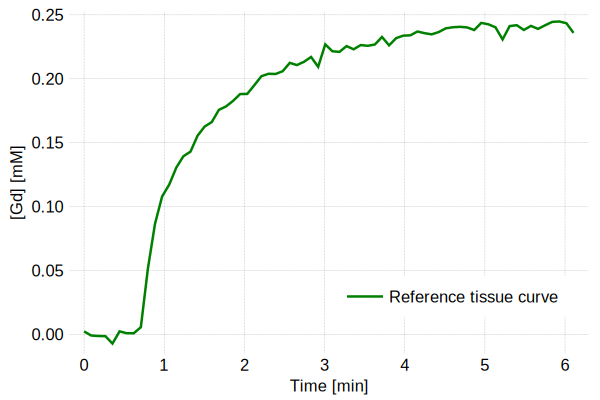

In [9]:
# Plot of the reference tissue curve (temporalis muscle)
plot(t, crr; lineopts("Reference tissue curve")..., c=:green, legend=:bottomright)

In [10]:
# Fit the same tumour voxel, but with the reference region model this time
est_errm = fit_errm(t = t, ct = single_ct, crr = crr)

(rel_kt = [1.0120112732105304], rel_ve = [-0.11917800561962306], rel_vp = [0.5360991512455678], kep = [0.12263746137670792], kep_rr = [-0.014442218627429337])

The extended reference region model provides estimates for:
$$
K^{trans}/K^{trans}_{RR} \qquad v_e/v_{e,RR} \qquad v_p/K^{trans}_{RR} \qquad k_{ep} \qquad k_{ep,RR}
$$
which are `rel_kt`, `rel_ve`, `rel_vp`, `kep` and `kep_rr` in the code, respectively. 
The parameters with the $RR$ subscript represent the reference tissue. 
In order to get $K^{trans}$, $v_e$, and $v_p$, we need to know the reference tissue's $K^{trans}_{RR}$ and $v_{e,RR}$.

Let's first look at the bright side: the reference region model provides en estimate for $k_{ep}$ without needing an input function.
Unfortunately, this value does not agree with the estimate we got earlier from the Tofts model:

In [11]:
println("""
kep estimated with: 
    - Tofts model: $(est_tofts.kep[1])
    - Ref.Region model: $(est_errm.kep[1])
Oh no, they don't match. :(    
""")

kep estimated with: 
    - Tofts model: 1.0327259084518505
    - Ref.Region model: 0.12263746137670792
Oh no, they don't match. :(    



Well, let's look at the *other* bright side: the reference region model provides an estimate for $k_{ep,RR}$. 
Each fit on a tumour voxel produces an estimate for $k_{ep,RR}$. 
In theory, all fits should estimate the same $k_{ep,RR}$ because this parameter described the reference tissue and all fits use the same reference tissue curve.
In practice, the estimated value varies due to noise and other fitting artifacts—for example, the voxel's estimated $k_{ep,RR}$ is -0.01 which is unphysical.
However, most of the fits should be centered around the same value.

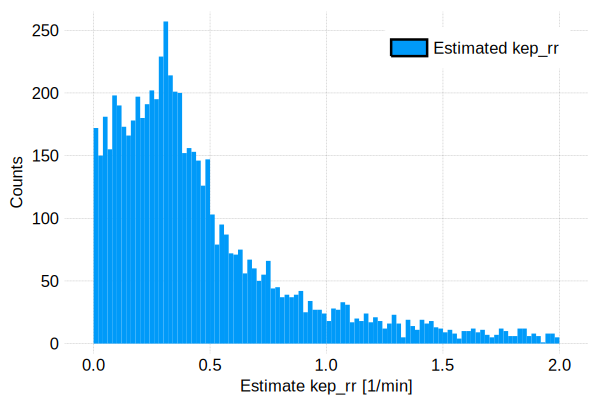

In [12]:
# Fit all tumour voxels with the extended reference region model
est_errm_allvoxels = fit_errm(t=t, ct=ct, crr=crr)
# Plot a histogram of the kep_rr estimates
histogram(est_errm_allvoxels.kep_rr[0 .< est_errm_allvoxels.kep_rr .< 2], bins=100, linealpha=0; 
    lineopts("Estimated kep_rr")..., xlabel="Estimate kep_rr [1/min]", ylabel="Counts")

There is a peak in the histogram close to 0.3~0.4.
We can estimate a single $k_{ep,RR}$ value by considering only the fits with positive estimates and then taking the interquartile mean of $k_{ep,RR}$ from those fits.

In [13]:
positive_mask = RRIFT.positive_only_mask(est_errm_allvoxels)
est_kep_rr = interquartile_mean(est_errm_allvoxels.kep_rr[positive_mask])

0.3923109294461705

Now that we have a single estimate for kep_rr, we can re-fit the reference region model but this time we force the fits to have the same kep_rr value.
This two-fit approach is called the constrained extended reference region model, and it leads to better agreement with the Tofts fit:

In [14]:
# Refit using a fixed kep_rr
est_cerrm = fit_cerrm(t = t, ct = single_ct, crr = crr, kep_rr = est_kep_rr)

println("""
kep estimated with: 
    - Tofts model: $(est_tofts.kep[1])
    - Constrained Ref.Region model: $(est_cerrm.kep[1])
The estimated values are similar. :)    
""")

kep estimated with: 
    - Tofts model: 1.0327259084518505
    - Constrained Ref.Region model: 1.0553217377130963
The estimated values are similar. :)    



### Reference region and input function tail (RRIFT) method

Let's return our attention to the fact that the reference region model gives us relative parameters. 
In order to get absolute parameters, we need to know the reference tissue parameters: $K^{trans}_{RR}$ and $v_{e,RR}$.
This is typically done by using literature-based values of muscle, but $K^{trans}_{RR}$ varies substantially between patients and between muscles.

The paper proposes RRIFT which takes advantages of two features:
1. We know $k_{ep,RR}$ already. This is useful because $k_{ep,RR} = K^{trans}_{RR}/v_{e,RR}$, so we only need to know either $K^{trans}_{RR}$ or $v_{e,RR}$.
2. The peak part of the input function `cp` is hard to measure, but the rest of the input function is fairly "flat" and could be measured with a slow scan. This "input function tail" is plotted next:

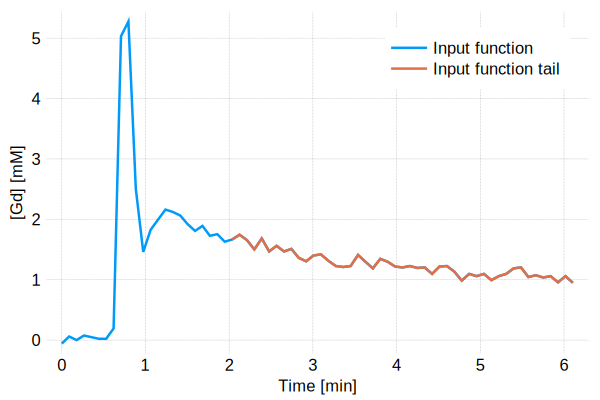

In [15]:
tail_start = findfirst(t .> 2)
plot(t, cp; lineopts("Input function")...)
plot!(t[tail_start:end], cp[tail_start:end]; lineopts("Input function tail")...)

The equation to estimate $K^{trans}_{RR}$ is:
$$
K^{trans}_{RR} = \frac{C_{RR}(t) - C_{RR}(t_{start}) + k_{ep,RR} \cdot \int_{t_{start}}^t C_{RR}(\tau) d\tau}{\int_{t_{start}}^t C_p(\tau) d\tau}
$$
where $t_{start}$ is the start of the AIF tail (2 minutes in the above example), $t$ is any timepoint after $t_{start}$, and we already estimated $k_{ep,RR}$ earlier from the reference region model.

The equation can be solved by linear regressing with $t = [t_{start+1}, ... ,t_{end}]$, as shown next:

Estimated Ktrans_rr from RRIFT fit: 0.0795
Estimated ve_rr: 0.2027


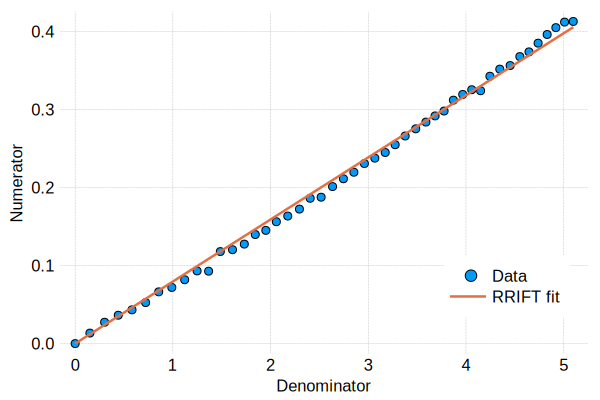

In [16]:
using NumericalIntegration: cumul_integrate

tail_start = findfirst(t .> 2)
crr_tail = crr[tail_start:end]
cp_tail = cp[tail_start:end]
t_tail = t[tail_start:end]

numerator = crr_tail .- crr_tail[1] .+ est_kep_rr .* cumul_integrate(t_tail, crr_tail)
denominator = cumul_integrate(t_tail, cp_tail)

est_kt_rr = denominator \ numerator
est_ve_rr = est_kt_rr / est_kep_rr
println("Estimated Ktrans_rr from RRIFT fit: $(round(est_kt_rr, digits=4))")
println("Estimated ve_rr: $(round(est_ve_rr, digits=4))")

scatter(denominator, numerator; lineopts("Data")..., legend=:bottomright)
plot!(denominator, denominator .* est_kt_rr; 
    lineopts("RRIFT fit")..., xlabel = "Denominator", ylabel="Numerator")

Now we can use the estimated $K^{trans}_{RR}$ and $v_{e,RR}$ to convert the relative estimates from the reference region model into absolute estimates.

In [17]:
est_tofts = fit_model(:extendedtofts, :lls, t = t, ct = single_ct, cp = cp).estimates
est_cerrm = fit_cerrm(t = t, ct = single_ct, crr = crr, kep_rr = est_kep_rr)

println("""
Comparisong between Toft and RRM+RRIFT
    - Tofts Ktrans: $(est_tofts.kt)
    - RRIFT Ktrans: $(est_cerrm.rel_kt .* est_kt_rr)
    --------------------------------------------
    - Tofts ve: $(est_tofts.ve)
    - RRIFT ve: $(est_cerrm.rel_ve .* est_ve_rr)
    -------------------------------------------
    - Tofts vp: $(est_tofts.vp)
    - RRIFT vp: $(est_cerrm.rel_vp .* est_kt_rr)
They're quite similar! :)
""")

Comparisong between Toft and RRM+RRIFT
    - Tofts Ktrans: [0.08883412510741831]
    - RRIFT Ktrans: [0.09310087206549063]
    --------------------------------------------
    - Tofts ve: [0.086019072805667]
    - RRIFT ve: [0.08822036800572508]
    -------------------------------------------
    - Tofts vp: [0.038510892935098386]
    - RRIFT vp: [0.035920132873421926]
They're quite similar! :)



## Voxel-wise fitting

The above was an example for a single tumour voxel. 
This section will use voxel-wise fitting to show that the maps using RRIFT and similar to the Tofts model.

In [18]:
tail_start = findfirst(t .> 2)
est_tofts = fit_model(:extendedtofts, :lls, t = t, ct = ct, cp = cp).estimates
est_rrift = fit_cerrm_with_rrift(t = t, ct = ct, cp = cp, crr = crr, tail_start = tail_start)
# Note: I didn't pass `kep_rr` as an input argument above. That's because the function will compute it on its own.

estimates = (tofts = est_tofts, rrift = est_rrift)

maps = Dict()
for param in keys(est_tofts)
    inner_dict = Dict()
    for method in (:tofts, :rrift)
        i_am_the_map = zeros(size(masks["tumour"]))
        i_am_the_map[masks["tumour"]] .= estimates[method][param]
        i_am_the_map = RRIFT.crop(i_am_the_map)
        inner_dict[method] = i_am_the_map
    end
    maps[param] = inner_dict
end
nothing # No output for this cell

In [ ]:
num_slices = size(masks["tumour"])[3]
clims = Dict(:kt => (0, 0.2), :kep => (0, 1), :ve => (0, 0.5), :vp => (0, 0.05))
@manipulate for param in collect(keys(maps)), slice in 1:num_slices
    p1 = heatmap(maps[param][:tofts][:,:,slice], c=:cinferno, yflip=true, aspect_ratio=:equal, clim=clims[param]; lineopts("")..., title="Tofts", axis=nothing, xlabel="", ylabel="")
    p2 = heatmap(maps[param][:rrift][:,:,slice], c=:cinferno, yflip=true, aspect_ratio=:equal, clim=clims[param]; lineopts("")..., title="RRIFT", axis=nothing, xlabel="", ylabel="")
    plot(p1, p2, layout=(1,2))
end

In [20]:
println("""
Concordance correlation coefficients between Tofts and RRIFT fits
    - for ktrans: $(ccc(est_tofts[:kt], est_rrift[:kt], lim=(0, 0.2)))
    - for ve: $(ccc(est_tofts[:ve], est_rrift[:ve], lim=(0, 0.5)))
    - for vp: $(ccc(est_tofts[:vp], est_rrift[:vp], lim=(0, 0.05)))
""")

Concordance correlation coefficients between Tofts and RRIFT fits
    - for ktrans: 0.9756413457779293
    - for ve: 0.9721007341873623
    - for vp: 0.9336773829305169

